In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Useful Resources

- https://msnews.github.io/#about-mind - data source
- https://github.com/microsoft/recommenders - implementation and practice of several existing news recommendation methods
- https://www.kaggle.com/datasets/arashnic/mind-news-dataset - dataset on kaggle

# Set Up

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette(sns.color_palette("seismic"))
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import string
import json
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from textblob import TextBlob
from wordcloud import WordCloud

# News Dataset

### Reading Data & Initial Info

In [3]:
# For google colab
df_news = pd.read_csv("/content/drive/MyDrive/Group_19/01.Dataset/Small/Original/Train/news.tsv", header=None, sep='\t')
df_news.columns = ['article_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities']

**news.tsv variables**
- article_id: unique id
- category: article genre
- subcategory: similar to category but more specific
- title: article title
- abstract: summary of article
- url: link to article
- title_entities: relevant entities extracted from titles of the news articles. Includes link to same entities in WikiData
- abstract_entities: similar to title_entities but extracted from abstract

_source: https://msnews.github.io/assets/doc/ACL2020_MIND.pdf_

In [4]:
df_news.head(2)

,article_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."


In [5]:
df_news.shape

(51282, 8)

In [6]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   article_id         51282 non-null  object
 1   category           51282 non-null  object
 2   subcategory        51282 non-null  object
 3   title              51282 non-null  object
 4   abstract           48616 non-null  object
 5   url                51282 non-null  object
 6   title_entities     51279 non-null  object
 7   abstract_entities  51278 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB


In [7]:
# check that IDs are unique
df_news.duplicated('article_id').sum()

0

In [8]:
# titles are not unique
df_news.duplicated('title').sum()

848

### NA Values

In [9]:
df_news.isna().sum()

article_id              0
category                0
subcategory             0
title                   0
abstract             2666
url                     0
title_entities          3
abstract_entities       4
dtype: int64

### Categories & Subcategories
- Category & Subcategory counts
- Categories by popularity
- Category & Subcategory distribution
- Top subcategories (for top 5 categories)
- Most common words per category
- Most common bigram per category

In [10]:
# Number of categories
df_news['category'].nunique()

17

In [11]:
# Number of articles per category
df_news.groupby('category')['subcategory'].count().sort_values(ascending=False)

category
news             15774
sports           14510
finance           3107
foodanddrink      2551
lifestyle         2479
travel            2350
video             2068
weather           2048
health            1885
autos             1639
tv                 889
music              769
movies             606
entertainment      587
kids                17
middleeast           2
northamerica         1
Name: subcategory, dtype: int64

In [12]:
# Number of subcategories
df_news['subcategory'].nunique()

264

In [13]:
# Top 10 overall subcategories
df_news.groupby('subcategory')['title'].count().sort_values(ascending=False).nlargest(10)

subcategory
newsus                      6564
football_nfl                5420
newspolitics                2826
newscrime                   2254
weathertopstories           2047
newsworld                   1720
football_ncaa               1665
baseball_mlb                1661
basketball_nba              1555
newsscienceandtechnology    1210
Name: title, dtype: int64

In [14]:
# Get the categories in order of popularity
category_order = [x for x, count in sorted(Counter(df_news['category']).items(), key=lambda x: -x[1])]

# Create a DataFrame with category counts
category_counts = df_news['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']
category_counts = category_counts.sort_values('category', key=lambda x: [category_order.index(c) for c in x])

# Create the count plot using Plotly
fig = px.bar(category_counts, x='category', y='count', title='Category Counts')
fig.update_layout(xaxis={'categoryorder': 'array', 'categoryarray': category_order})

# Display the plot
fig.show()

In [15]:
c=df_news[['category','subcategory']].value_counts()

index=[]
for i in c.index:
    index.append(np.array(i))
index=np.array(index)

distribution_df=pd.DataFrame(columns=['category','subcategory','values'])
distribution_df['category']=index[:,0]
distribution_df['subcategory']=index[:,1]
distribution_df['values']=c.values

px.bar(data_frame=distribution_df,x='category',y='values',color='subcategory')

In [16]:
# top 5 most popular subcategories for each of the top 5 categories
top_categories = df_news['category'].value_counts().nlargest(5).index

# Generate count plots for subcategories within each top category
for category in top_categories:
    subcategory_counts = df_news[df_news['category'] == category]['subcategory'].value_counts().nlargest(10)
    fig = px.bar(subcategory_counts, x=subcategory_counts.index, y=subcategory_counts.values,
                 labels={'x': 'subcategory', 'y': 'Count'}, title=f"Subcategories for {category}")
    fig.update_xaxes(tickangle=50)
    fig.show()


In [17]:
# Top 5 words in each category

from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
import nltk

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Get the set of English stopwords
stop_words = set(stopwords.words('english'))

# Group the data by category
grouped = df_news.groupby('category')

# Iterate over each category
for category, group in grouped:
    titles = ' '.join(group['title'])  # Concatenate all titles for the category
    words = titles.split()  # Split the concatenated titles into individual words

    # Remove stopwords from the list of words
    words = [word.strip(' "\'') for word in words if word.lower() not in stop_words and word != '-']

    word_counts = Counter(words)  # Count the occurrences of each word

    # Find the top 5 most common words
    top_words = word_counts.most_common(5)

    print(f"{category}:")
    for word, count in top_words:
        print(f"{word} ({count})")
    print()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


autos:
2020 (174)
crash (153)
Ford (97)
Car (97)
New (74)

entertainment:
2019 (73)
news (37)
Halloween (34)
plus (33)
Stars (29)

finance:
new (104)
US (86)
says (78)
million (76)
Microsoft (73)

foodanddrink:
Thanksgiving (209)
Recipes (167)
New (165)
Best (139)
Make (124)

health:
Weight (76)
Here's (71)
Health (70)
Pounds (58)
cancer (56)

kids:
Here's (2)
White (2)
Americans (1)
Use (1)
Fahrenheit (1)

lifestyle:
Halloween (88)
Best (87)
Meghan (86)
Prince (80)
Things (63)

middleeast:
killing (2)
Saudi (1)
says (1)
Baghdadi (1)
distorted (1)

movies:
Trailer (73)
Jennifer (28)
The (28)
Movie (21)
John (19)

music:
Awards (48)
2019 (47)
New (46)
CMA (40)
Music (39)

news:
Trump (1177)
police (564)
says (557)
Man (553)
man (518)

northamerica:
Republicans (1)
floated (1)
17 (1)
different (1)
defenses (1)

sports:
vs. (745)
Week (743)
win (650)
NFL (551)
State (480)

travel:
New (112)
new (80)
Best (75)
Day (59)
best (57)

tv:
TV (63)
The (42)
Says (33)
New (30)
Joe (25)

video:
Tru

In [18]:
# Top 5 words bi grams in each category

from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
import nltk

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Get the set of English stopwords
stop_words = set(stopwords.words('english'))

# Group the data by category
grouped = df_news.groupby('category')

# Iterate over each category
for category, group in grouped:
    titles = ' '.join(group['title'])  # Concatenate all titles for the category
    words = titles.split()  # Split the concatenated titles into individual words

    # Remove stopwords from the list of words
    words = [word.strip(' "\'') for word in words if word.lower() not in stop_words and word != '-']

    # Generate bi-grams
    bi_grams = list(nltk.bigrams(words))

    bi_gram_counts = Counter(bi_grams)  # Count the occurrences of each bi-gram

    # Find the top 5 most common bi-grams
    top_bi_grams = bi_gram_counts.most_common(5)

    print(f"{category}:")
    for bi_gram, count in top_bi_grams:
        print(f"{' '.join(bi_gram)} ({count})")
    print()

autos:
Ford Mustang (23)
2020 Ford (19)
Mustang Shelby (13)
Shelby GT500 (13)
crash involving (13)

entertainment:
plus news (24)
People's Choice (22)
Choice Awards (16)
Kylie Jenner (9)
2019 People's (8)

finance:
Apartments rent (42)
get you? (42)
Social Security (18)
737 Max (17)
right now? (14)

foodanddrink:
Thanksgiving Recipes (26)
Every State (23)
Thanksgiving Dinner (21)
Veterans Day (19)
Trader Joe's (18)

health:
Weight Loss (29)
Lose Weight (19)
Breast Cancer (18)
breast cancer (13)
Need Know (11)

kids:
Americans Use (1)
Use Fahrenheit (1)
Fahrenheit Instead (1)
Instead Celsius (1)
Celsius Take (1)

lifestyle:
Meghan Markle (57)
Kate Middleton (34)
Prince Harry (31)
Veterans Day (19)
Zodiac Sign (16)

middleeast:
Saudi says (1)
says Baghdadi (1)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Baghdadi distorted (1)
distorted image (1)
image Islam, (1)

movies:
Jennifer Aniston (11)
Box Office (10)
Kevin Hart (9)
Charlize Theron (9)
Star Wars (8)

music:
CMA Awards (29)
Taylor Swift (22)
Kanye West (16)
Elton John (15)
Carrie Underwood (14)

news:
police say (201)
White House (124)
impeachment inquiry (106)
Apartments rent (82)
get you? (82)

northamerica:
Republicans floated (1)
floated 17 (1)
17 different (1)
different defenses (1)
defenses Trump's (1)

sports:
World Series (235)
Week 10 (141)
Tom Brady (101)
high school (99)
Week 9 (95)

travel:
Veterans Day (38)
New York (21)
American Airlines (19)
St. Louis (14)
Day Parade (14)

tv:
Jennifer Aniston (15)
Kim Kardashian (14)
TV shows (13)
Felicity Huffman (13)
Joe Giudice (11)

video:
impeachment inquiry (36)
impeachment hearings (35)
impeachment hearing (24)
public impeachment (23)
President Trump (17)

weather:
Kincade Fire (26)
New South (21)
South Wales (21)
First Alert (21)
Bay Area (20)



### Title Words
- Titles by popularity
- Titles by popularity & category
- Word count & unique word count
- Stop word count
- Mean word length
- Character count
- Punctuation count
- Word clouds of titles in top 3 categories

In [19]:
# top 10 most popular titles
df_news['title'].value_counts().nlargest(10)

Photos of the Day                                                               15
Look of the Day                                                                 14
Friday's Scores                                                                  8
Video appears to show Astros stealing signs against Danny Farquhar               6
Winter already? Snow, deep freeze from Rockies to East Coast                     5
Morning news briefing from CNN                                                   5
Yu Darvish sends hilarious tweet about Astros cheating scandal                   5
Sunday Real Estate: 3 Luxurious Florida Homes                                    5
Microsoft vows to 'honor' California's sweeping privacy law across entire US     5
This company will pay you $1,000 to watch Hallmark Christmas movies              5
Name: title, dtype: int64

In [20]:
# most popular titles per category
df_news.groupby('category')['title'].value_counts().nlargest(10)

category      title                                                                        
news          Photos of the Day                                                                15
lifestyle     Look of the Day                                                                  14
sports        Video appears to show Astros stealing signs against Danny Farquhar                6
foodanddrink  Thanksgiving Recipe Searches Reveal Florida's Tastes                              5
music         New and upcoming releases                                                         5
news          Microsoft vows to 'honor' California's sweeping privacy law across entire US      5
sports        Friday's Scores                                                                   5
              Yankees make crucial error against Jose Altuve in 9th inning of ALCS clincher     5
              Yu Darvish sends hilarious tweet about Astros cheating scandal                    5
video         Morning news

In [21]:
# analyzing titles
df_word_count = df_news.copy()

# title polarity
df_word_count['title_polarity'] = df_word_count['title'].apply(lambda x: TextBlob(x).sentiment.polarity)

# word_count
df_word_count['title_word_count'] = df_word_count['title'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_word_count['title_unique_word_count'] = df_word_count['title'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_word_count['title_stop_word_count'] = df_word_count['title'].apply(lambda x: len([w for w in str(x).lower().split() if w in nltk.corpus.stopwords.words("english")]))

# mean_word_length
df_word_count['title_mean_word_length'] = df_word_count['title'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_word_count['title_char_count'] = df_word_count['title'].apply(lambda x: len(str(x)))

# punctuation_count
df_word_count['title_punctuation_count'] = df_word_count['title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [22]:
# Select columns to make histograms for
columns = ['title_polarity', 'title_word_count', 'title_unique_word_count', 'title_stop_word_count',
           'title_mean_word_length', 'title_char_count', 'title_punctuation_count']

# Create subplots using make_subplots
num_subplots = len(columns)
fig = make_subplots(rows=num_subplots, cols=1, subplot_titles=columns, row_heights=[5] * num_subplots)

# Create histograms for each column
for i, column in enumerate(columns, start=1):
    fig.add_trace(go.Histogram(x=df_word_count[column], nbinsx=100), row=i, col=1)

# Update the layout of subplots
fig.update_layout(height=1000, width=800, showlegend=False)

# Display the plot
fig.show()


In [23]:
# word count per category
df_word_count_grouped = df_word_count.groupby('category')['title_word_count'].mean().reset_index().sort_values(by='title_word_count', ascending=False)

fig = px.bar(df_word_count_grouped, x='category', y='title_word_count')
fig.show()

In [24]:
# average polarity per category
df_word_count_grouped = df_word_count.groupby('category')['title_polarity'].mean().reset_index().sort_values(by='title_polarity', ascending=False)

fig = px.bar(df_word_count_grouped, x='category', y='title_polarity')
fig.show()

#### Word Clouds (from titles) per Category

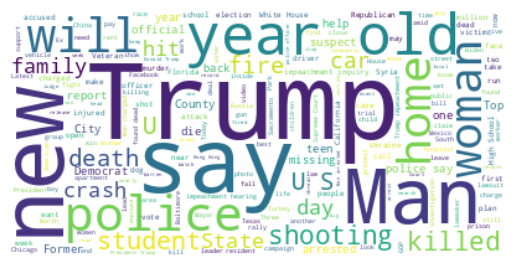

In [25]:
# news category
text=' '
for i in df_news[df_news['category']=='news']['title']:
    text+=i+' '

# Make the figure
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

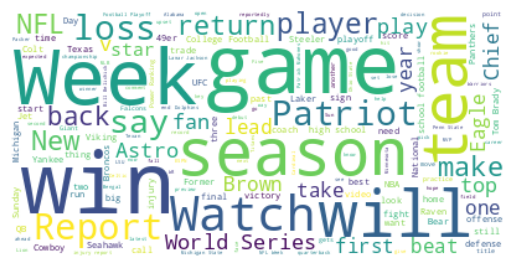

In [26]:
# sports category
text=' '
for i in df_news[df_news['category']=='sports']['title']:
    text+=i+' '

# Make the figure
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

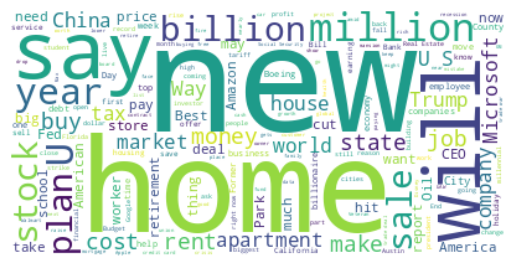

In [27]:
# finance category
text=' '
for i in df_news[df_news['category']=='finance']['title']:
    text+=i+' '

# Make the figure
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

### Abstract Words
- Abstracts by popularity
- Word count & unique word count
- Stop word count
- Mean word length
- Character count
- Punctuation count
- Word clouds of abstracts in top 3 categories

In [28]:
# There are repeated abstracts
df_news.duplicated('abstract').sum()

3972

In [29]:
# Count of NA abstracts per category
df_news.groupby('category')['abstract'].apply(lambda x: x.isna().sum()).sort_values(ascending=False)

category
sports           1279
news              571
weather           169
lifestyle         160
autos             137
travel            127
finance            59
health             51
foodanddrink       38
entertainment      31
tv                 21
music              15
movies              4
video               3
kids                1
middleeast          0
northamerica        0
Name: abstract, dtype: int64

In [30]:
# top 10 most popular abstracts
df_news['abstract'].value_counts().nlargest(10)

What's the weather today? What's the weather for the week? Here's your forecast.                                                                                                                                                                                                                                       124
Trailer 1                                                                                                                                                                                                                                                                                                               27
Our top photos from the last 24 hours.                                                                                                                                                                                                                                                                                  16
Official Trailer                                       

In [31]:
# convert abstract column to string
df_word_count['abstract'] = df_word_count['abstract'].to_string()

In [ ]:
# polarity
df_word_count['abstract_polarity'] = df_word_count['abstract'].apply(lambda x: TextBlob(x).sentiment.polarity)

# word_count
df_word_count['abstract_word_count'] = df_word_count['abstract'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_word_count['abstract_unique_word_count'] = df_word_count['abstract'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_word_count['abstract_stop_word_count'] = df_word_count['abstract'].apply(lambda x: len([w for w in str(x).lower().split() if w in nltk.corpus.stopwords.words("english")]))

# mean_word_length
df_word_count['abstract_mean_word_length'] = df_word_count['abstract'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_word_count['abstract_char_count'] = df_word_count['abstract'].apply(lambda x: len(str(x)))

# punctuation_count
df_word_count['abstract_punctuation_count'] = df_word_count['abstract'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [ ]:
# Select columns to make histograms for
columns = ['abstract_polarity', 'abstract_word_count', 'abstract_unique_word_count', 'abstract_stop_word_count', 'abstract_mean_word_length', 'abstract_char_count', 'abstract_punctuation_count']

# Create subplots using make_subplots
num_subplots = len(columns)
fig = make_subplots(rows=num_subplots, cols=1, subplot_titles=columns, row_heights=[5] * num_subplots)

# Create histograms for each column
for i, column in enumerate(columns, start=1):
    fig.add_trace(go.Histogram(x=df_word_count[column], nbinsx=100), row=i, col=1)

# Update the layout of subplots
fig.update_layout(height=1000, width=800, showlegend=False)

# Display the plot
fig.show()

In [ ]:
# weather is the category with the highest average word count
df_word_count.groupby('category')['abstract_word_count'].mean().sort_values(ascending=False)

In [ ]:
# average polarity per category
df_word_count_grouped = df_word_count.groupby('category').mean().reset_index()

fig = px.bar(df_word_count_grouped, x='category', y='abstract_polarity')
fig.show()

#### Word Clouds (from abstracts) per Category

In [ ]:
# news category
text=' '
for i in df_news[df_news['category']=='news']['abstract']:
  if isinstance(i, str):
    text+=i+' '

# Make the figure
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

In [ ]:
# sports category
text=' '
for i in df_news[df_news['category']=='sports']['abstract']:
   if isinstance(i, str):
    text+=i+' '

# Make the figure
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

In [ ]:
# finance category
text=' '
for i in df_news[df_news['category']=='finance']['abstract']:
   if isinstance(i, str):
    text+=i+' '

# Make the figure
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

### Title Entities
- Most & least common entities

In [ ]:
# define function to extract any metric from any of the entities columns

def entities(df, col_number, metric):
    entities = df.iloc[:, col_number]
    entities = entities.dropna()

    labels = []

    for entity in entities:
        entity = json.loads(entity)

        for dictionary in entity:
            labels.append(dictionary[metric])

    return labels

In [ ]:
title_labels = entities(df_news, 6, 'Label')

In [ ]:
# find 10 most and least popular labels
title_label_counter = Counter(title_labels)

bottom_10_title_labels = title_label_counter.most_common()[::-1][:10]
top_10_title_labels = title_label_counter.most_common(10)

In [ ]:
top_10_title_labels

In [ ]:
bottom_10_title_labels

In [ ]:
# extract types from entities
title_types = set(entities(df_news, 6, 'Type'))
title_types

### Abstract Entities
- Most & least common entities

In [ ]:
# extract abstract labels
abstract_labels = entities(df_news, 7, 'Label')

In [ ]:
# find 10 most and least popular labels
abstract_label_counter = Counter(abstract_labels)

bottom_10_abstract_labels = abstract_label_counter.most_common()[::-1][:10]
top_10_abstract_labels = abstract_label_counter.most_common(10)

In [ ]:
top_10_abstract_labels

In [ ]:
bottom_10_abstract_labels

In [ ]:
# extract abstract types
abstract_types = set(entities(df_news, 7, 'Type'))
abstract_types

### News Release Dates

In [ ]:
df_dates = pd.read_pickle("/content/drive/MyDrive/Group_19/01.Dataset/Small/Clean/Train/news.pkl")

#df_dates = pd.read_csv('news_with_dates.csv')

In [ ]:
df_dates

In [ ]:
# df_dates['release_date'] = pd.to_datetime(df_dates['release_date'])

In [ ]:
daily_counts = df_dates.resample('H', on='Release Date').size()

# Create the time series plot using Plotly
fig = px.line(x=daily_counts.index, y=daily_counts.values)
fig.update_layout(
    xaxis_title="Release Date",
    yaxis_title="Number of Articles",
    title="Articles Released Over Time"
)
fig.show()

### Key findings:
- **NA values**:
    - 2666 in 'abstracts'
    - 4 in 'title_entities'
    - 3 in 'abstract_entities'
- **Categories & Subcategories**:
    - 17 Categories (top category: 'news')
    - 264 Subcategories (top subcategory: newsus)
- **Titles & Abstracts**:
    - Titles are not unique (top title: 'Photos of the Day')
    - Abstracts are not unique (3972 duplicates, top duplicates: weather, photos of the day, trailers)
    - Sports is the category with the most NA values in 'abstracts' so is likely to have shorter text which may impact content based filtering
    - There seem to be short & long abstracts
    - Weather is the category with the largest titles & abstracts (measured by word count)
    - Most titles have a neutral sentiment (polarity = 0)
- **Entities**:
    - Top 5 most common title entities are: Donald Trump, National Football League, United States, New England Patriots, and Houston Astros
    - Top 5 most common abstract entities are: Donald Trump, United States, National Football League, California, and New England Patriots
    - Entities have a 'type' ranging from A to Y (not sure what they are)
- **News Release Dates**:
    - Most articles were already available at the first time stamp present in the dataset

# Behaviours Dataset

### Reading Data & Initial Info

In [ ]:
df_behaviors = pd.read_csv("/content/drive/MyDrive/Group_19/01.Dataset/Small/Original/Train/behaviors.tsv", header=None, sep='\t')
df_behaviors.columns = ['impression_id', 'user_id', 'timestamp', 'history', 'impressions']

**behaviors.tsv variables**
- impression_id: unique ID of an impression
- user_id: anonymous ID of a user
- timestamp: impression time with format "MM/DD/YYYY HH:MM:SS AM/PM"
- history: news click history (ID list of clicked news) of this user before this impression. The clicked news articles are ordered by time.
- impressions: list of news displayed in this impression and user's click behaviors on them (1 for click and 0 for non-click). The orders of news in a impressions have been shuffled.

_source: https://www.kaggle.com/datasets/arashnic/mind-news-dataset_

In [ ]:
df_behaviors.shape

In [ ]:
df_behaviors.info()

In [ ]:
df_behaviors.head(3)

In [ ]:
# convert timestamp to date time
df_behaviors['timestamp'] = pd.to_datetime(df_behaviors['timestamp'])

In [ ]:
print(df_behaviors['timestamp'].min())
print(df_behaviors['timestamp'].max())

In [ ]:
# unique number of user IDs
df_behaviors['user_id'].nunique()

In [ ]:
# unique number of histories
df_behaviors['history'].nunique()

### NA Values

In [ ]:
df_behaviors.isna().sum()

In [ ]:
df_behaviors.head(2)

### Time Series

In [ ]:
df_behaviors['hour'] = pd.to_datetime(df_behaviors['timestamp']).dt.hour
hourly_counts = df_behaviors['hour'].value_counts().sort_index()

In [ ]:
fig = px.bar(x=hourly_counts.index, y=hourly_counts.values)
fig.update_layout(
    xaxis_title="Hour of the day",
    yaxis_title="Total number of rows",
    title="Total Number of Rows per Hour"
)
fig.show()


In [ ]:
daily_counts = df_behaviors.resample('H', on='timestamp').size()

# Create the time series plot using Plotly
fig = px.line(x=daily_counts.index, y=daily_counts.values)
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Count of rows",
    title="Impressions over Time"
)
fig.show()

In [ ]:
# Number of users with empty history
print('number of empty history users: ', df_behaviors.loc[df_behaviors['history'] == 0].shape[0])

### Unique Users

In [ ]:
# User with max number of rows
df_behaviors.groupby('user_id').size().max()

In [ ]:
# Count number of articles in the history column in each row
df_behaviors['history_number'] = df_behaviors['history'].apply(lambda x: len(str(x).split()))

# Find the maximum number of articles in the history column and its count
print('Max number of articles in history:', df_behaviors['history_number'].max())
print('Number of rows with', df_behaviors['history_number'].max(), 'rows:', df_behaviors[df_behaviors['history_number'] == df_behaviors['history_number'].max()].shape[0])

In [ ]:
# Create a histogram trace
histogram_trace = go.Histogram(
    x=df_behaviors['history_number'],
    nbinsx=200  # Number of bins for the histogram
)

# Create the layout for the histogram
layout = go.Layout(
    title='Histogram of History Numbers',
    xaxis=dict(title='History Number'),
    yaxis=dict(title='Count')
)

# Create the Figure object
fig = go.Figure(data=[histogram_trace], layout=layout)

fig.show()

In [ ]:
# convert history to string
df_behaviors['history'] = df_behaviors['history'].astype(str)

# group by user and concatente histories
grouped_by_user = df_behaviors.groupby('user_id')['history'].agg(lambda x: ' '.join(x))

# calculate max history articles per user
print(grouped_by_user.apply(lambda x: len(str(x).split(' '))).max())

### Unique Users (Clean - Duplicates Removed)

In [ ]:
unique_user_behaviors_train = pd.read_csv("/content/drive/MyDrive/Group_19/01.Dataset/Small/Clean/Train/unique_user_behaviors_train.csv")

In [ ]:
unique_user_behaviors_train.head()

In [ ]:
# create column for number of articles read
unique_user_behaviors_train['history_number'] = unique_user_behaviors_train['History'].apply(lambda x: len(str(x).split()))

In [ ]:
# Create a histogram trace
histogram_trace = go.Histogram(
    x=unique_user_behaviors_train['history_number'],
    nbinsx=500  # Number of bins for the histogram
)

# Create the layout for the histogram
layout = go.Layout(
    title='Number of Articles Read',
    xaxis=dict(title='Number of Articles'),
    yaxis=dict(title='Count of Users')
)

# Create the Figure object
fig = go.Figure(data=[histogram_trace], layout=layout)

fig.show()

### Key Findings:
- 3238 NA values in 'history' column
- Data on 50000 users
- Data on 48868 unique histories
- Data from September 9, 2019 - November 14, 2019
- Not all users have a history
- User with most rows in dataset has 62 rows
- Most articles in history in a single row: 558
- User with most articles in hisotry has 18972 articles (weird...)